# Neural network methods

Author: Gaurav Vaidya

## Learning objectives
* Understand what an artificial neural network (ANN) is and how it can be used.
* Implement ANNs for use in prediction and classification based on multiple input features.

## Learning deeply
[Artificial Neural Networks (ANNs)](https://en.wikipedia.org/wiki/Artificial_neural_network) and [deep learning](https://en.wikipedia.org/wiki/Deep_learning) are currently getting a lot of interest, both as a subject of research and as a tool for analyzing datasets. A big difference from other machine learning techniques we've looked at so far is that ANNs can identify characteristics of interest by themselves, rather than having to be chosen by data scientists. Some of the other advantages of ANNs are related specifically to interpreting video and audio data, such as by using [convolutional neural networks](https://en.wikipedia.org/wiki/Convolutional_neural_network), but today we will focus on simple ANNs so you understand their struction and function.

### Units

ANNs are designed as *layers* of *units* (or nodes, or [artificial neurons](https://en.wikipedia.org/wiki/Artificial_neuron)). Each unit accepts multiple inputs, each of which has a different weight, including one bias input, which it combines into a single value. That single value is passed to an [activation function](https://en.wikipedia.org/wiki/Activation_function), which provides an output only if the combined value is greater than a particular threshold (usually, zero).

In effect, each unit focuses on a particular aspect of the layer underneath it, and then summarizing that information for the layer above it. Every input to every unit has a *weight* and the unit has a *bias* input, and so is effectively doing a linear regression on the incoming data to obtain an output. The use of a non-linear activation function allows the ANN to predict and classify data that are not [linearly separable](https://en.wikipedia.org/wiki/Linear_separability). ANNs used to use the same sigmoid function we saw before, but these days the [rectified linear unit (ReLU) function](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) has become much more popular. It simply returns zero when the real output value is less than zero.

![ReLU and softmax rectifiers](800px-Rectifier_and_softplus_functions.svg.png )

### Layers

![A diagram showing input, output and hidden layers in an ANN](../nb-images/colored_neural_network.svg.png)

Every neural network has three layers:

* An input layer, where each unit corresponds to a particular input feature. This could be categorical data, continuous data, or even colour values from images.
* An output layer. We will be running two examples today: in the first, we will use a single output unit (the predicted price for a particular house in California). In the second, we will use seven output units, each corresponding to a particular type of forest cover.
* A hidden layer. Without a hidden layer, an ANN can only pick up linear relationships: how changes in the input layer correspond to values in the output layer. Thanks to the hidden layer, an ANN can also pick up non-linear relationships, where different groups of input values interact in complicated ways to get the correct response on the output layer. The "deep" in [deep learning](https://en.wikipedia.org/wiki/Deep_learning) refers to the hidden layers that allow the model to identify intermediate patterns between the input and output layers.

Putting it all together, we end up with a type of ANN called a *multilayer perceptron (MLP) network*, which looks like the following:

![A visualization of a multi-layer perceptron (MLP) from the Scikit-learn manual](../nb-images/multilayerperceptron_network.png)

[Google's Machine Learning course](https://developers.google.com/machine-learning/crash-course/introduction-to-neural-networks/anatomy) puts this very nicely: "Stacking nonlinearities on nonlinearities lets us model very complicated relationships between the inputs and the predicted outputs. In brief, each layer is effectively learning a more complex, higher-level function over the raw inputs."

## So what do we need?
To create an ANN, we need to choose:
1. The number of input units (= the number of input features)
2. The number of output units:
    - When using the ANN to predict, we generally only need a single output unit.
    - When using the ANN to classify, we generally set the number of output units to the number of possible labels.
3. The number of hidden layers
    - More hidden layers allows for more complex models -- which, as you've learned, also increases your risk of overfitting! So you want to go for the simplest model that meets your needs.
4. A loss function. The scikit-learn classes we use always use [logistic loss](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html), also known as cross-entropy loss.
4. The solver to use. The solver controls learning by searching for local minima in the parameter space. ANNs generally use [stochastic gradient descent (SGD)](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) such as [RMSProp](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#RMSProp), but today we will use [Adaptive Moment Estimation (Adam)](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Adam).
5. The regularization protocol. We will use L2 regularization.

Note that these are the [hyperparameters](https://en.wikipedia.org/wiki/Hyperparameter_(machine_learning)) of our model: we will adjust these hyperparameters to improve how quickly and accurately we can determine the actual parameters of our model, which is the set of weights and biases on all units across all layers.

## Reminders of the ground rules
* Always have *training* data and *testing* data, and make sure the ANN *never* sees the testing data.
* It's usually a good idea to work with shuffled data.
* ANNs aren't good when the data is in different ranges: it's usually a good idea to normalize it before use.

## ANN for prediction: how much might this house cost?

There aren't very good datasets for showcasing prediction on biological data, so we will use one of the classic machine learning datasets: a dataset of [California house prices](https://www.kaggle.com/camnugent/california-housing-prices), based on the 1990 census and published in [Pace and Barry, 1997](https://doi.org/10.1016/S0167-7152(96)00140-X). Scikit-Learn can download this dataset for us, so let's start with that.

In [224]:
from sklearn import datasets
help(datasets.fetch_california_housing)

Help on function fetch_california_housing in module sklearn.datasets.california_housing:

fetch_california_housing(data_home=None, download_if_missing=True, return_X_y=False)
    Load the California housing dataset (regression).
    
    ==============     ==============
    Samples total               20640
    Dimensionality                  8
    Features                     real
    Target             real 0.15 - 5.
    ==============     ==============
    
    Read more in the :ref:`User Guide <california_housing_dataset>`.
    
    Parameters
    ----------
    data_home : optional, default: None
        Specify another download and cache folder for the datasets. By default
        all scikit-learn data is stored in '~/scikit_learn_data' subfolders.
    
    download_if_missing : optional, default=True
        If False, raise a IOError if the data is not locally available
        instead of trying to download the data from the source site.
    
    
    return_X_y : boolean, def

In [225]:
import numpy as np
import pandas as pd

# Fetch California housing dataset. This will be downloaded to your computer.
calif = datasets.fetch_california_housing()
print("Shape of California housing data: ", calif.data.shape)
califdf = pd.DataFrame.from_records(calif.data)
califdf.head()

Shape of California housing data:  (20640, 8)


,0,1,2,3,4,5,6,7
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


Let's start by shuffling our data and splitting into testing data (640 rows) and training data (the remaining 20,000 rows).

In [231]:
# SkLearn has a shuffle method that can shuffle two arrays together,
# allowing us to shuffle both the features and the known labels without
# disrupting their order.
from sklearn.utils import shuffle
calif_data, calif_labels = shuffle(calif.data, calif.target)

# Use a portion of the data as testing data.
test_data = calif_data[0:640]
test_labels = calif_labels[0:640]
print("Test data shape: ", test_data.shape)
print("Test label shape: ", test_labels.shape)

# Use the remaining data as training data
train_data = calif_data[640:]
train_labels = calif_labels[640:]
print("Train data shape: ", train_data.shape)
print("Train label shape: ", train_labels.shape)

Test data shape:  (640, 8)
Test label shape:  (640,)
Train data shape:  (20000, 8)
Train label shape:  (20000,)


In [227]:
# Let's have a look at the data. Is it in similar ranges?
import pandas as pd
pd.DataFrame(train_data, columns=calif.feature_names).describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,3.868343,28.640050,5.424334,1.096235,1426.522250,3.073534,35.636357,-119.572959
std,1.899128,12.581502,2.477322,0.475239,1135.538906,10.549575,2.138587,2.003756
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000
25%,2.562500,18.000000,4.438917,1.006260,788.000000,2.429279,33.930000,-121.800000
50%,3.532750,29.000000,5.226958,1.048780,1166.000000,2.817544,34.260000,-118.500000
75%,4.744075,37.000000,6.048902,1.099415,1725.000000,3.280553,37.720000,-118.010000
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000


The input data comes in many different ranges: compare the ranges of latitude (32.54 to 41.95), longitude (-124.35 to -114.31), median income (0.50 to 15.0) and population (3 to 35682). As we described earlier, it's a good idea to normalize these values. Scikit-Learn has several built-in scalers that do just this. We will use the [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html), which changes the data so it is normally distributed, with a mean of 0 and a variance of 1, but other [standardization methods are available](https://scikit-learn.org/stable/modules/preprocessing.html#standardization-or-mean-removal-and-variance-scaling).

In [232]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Figure out how to scale all the input features in the training dataset.
scaler.fit(train_data)
scaled_train_data = scaler.transform(train_data)

# Also tranform our validation and testing data in the same way.
scaled_test_data = scaler.transform(test_data)

# Did that work?
pd.DataFrame(scaled_train_data, columns=calif.feature_names).describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,2.000000e+04,2.000000e+04,2.000000e+04,2.000000e+04,2.000000e+04,2.000000e+04,2.000000e+04,2.000000e+04
mean,-1.877645e-14,-6.625811e-17,5.262990e-15,-7.957368e-15,4.547474e-17,-1.338663e-15,-9.251977e-15,1.660929e-13
std,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00
min,-1.775947e+00,-2.195453e+00,-1.836716e+00,-1.594491e+00,-1.253300e+00,-2.257011e-01,-1.447654e+00,-2.387054e+00
25%,-6.877061e-01,-8.462098e-01,-3.972292e-01,-1.898027e-01,-5.628451e-01,-6.108699e-02,-7.964592e-01,-1.114134e+00
50%,-1.764392e-01,2.683010e-02,-8.043609e-02,-1.006847e-01,-2.290663e-01,-2.430699e-02,-6.465438e-01,5.381671e-01
75%,4.580209e-01,6.617682e-01,2.489603e-01,4.980713e-03,2.649967e-01,1.971641e-02,9.744162e-01,7.777757e-01
max,5.864446e+00,1.852277e+00,5.470333e+01,6.883005e+01,3.016858e+01,1.175681e+02,2.960795e+00,2.624758e+00


Alright, we're ready to run our model! We will use the [MLPRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html) -- MLP stands for [multilevel perceptron](https://en.wikipedia.org/wiki/Multilayer_perceptron), a description of this kind of neural network.

In [191]:
from sklearn.neural_network import MLPRegressor

ann = MLPRegressor(
    activation='relu',  # The activation function to use: ReLU
    solver='adam',      # The solver to use
    alpha=0.001,        # The L2 regularization rate: higher values increase cost for larger weights
    hidden_layer_sizes=(100, 20),
                        # The number of units in each hidden layer.
                        # Note that we don't need to specify input and output neuron numbers:
                        # MLPClassifier determines this based on the shape of the features and labels
                        # being fitted.
    verbose=True,       # Report on progress.
    batch_size='auto',  # Process dataset in batches of 200 rows at a time.
    early_stopping=True # This activates two features:
                        #  - We will hold 10% of data aside as validation data. At the end of each
                        #    iteration, we will test the validation data to see how well we're doing.
                        #  - If learning slows below a pre-determined level, we stop early rather than
                        #    overtraining on our data.
)
ann.fit(scaled_train_data, train_labels)

Iteration 1, loss = 0.98128534
Validation score: 0.419891
Iteration 2, loss = 0.33635107
Validation score: 0.568898
Iteration 3, loss = 0.25663779
Validation score: 0.642041
Iteration 4, loss = 0.22362402
Validation score: 0.671661
Iteration 5, loss = 0.20866553
Validation score: 0.688532
Iteration 6, loss = 0.19952123
Validation score: 0.705023
Iteration 7, loss = 0.19196451
Validation score: 0.716559
Iteration 8, loss = 0.18646636
Validation score: 0.724928
Iteration 9, loss = 0.18221476
Validation score: 0.730734
Iteration 10, loss = 0.17907250
Validation score: 0.734858
Iteration 11, loss = 0.17538714
Validation score: 0.740256
Iteration 12, loss = 0.17181941
Validation score: 0.743008
Iteration 13, loss = 0.16921575
Validation score: 0.748105
Iteration 14, loss = 0.16624208
Validation score: 0.749254
Iteration 15, loss = 0.16344204
Validation score: 0.751968
Iteration 16, loss = 0.16113209
Validation score: 0.757984
Iteration 17, loss = 0.15892381
Validation score: 0.758862
Iterat

MLPRegressor(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(100, 20), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=True, warm_start=False)

Three things to note:
 - Some models will never converge, in which case you will see a warning. This suggests that learning is *not* completely, and is likely because something is wrong with learning using this dataset with these hyperparameters.
 - We learn iteratively. In Scikit-Learn, each iteration is further broken up into "batches" of data.
 - We expect to see loss going down over time and validation score going up over time. We can visualize these in a graph if we want.

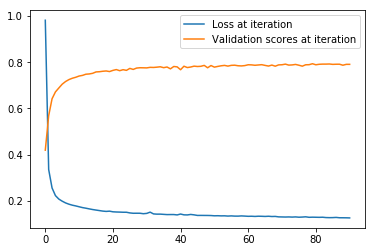

In [206]:
import matplotlib.pyplot as plt

# Visualize the loss curve and validation scores over iterations.
plt.plot(ann.loss_curve_, label='Loss at iteration')
plt.plot(ann.validation_scores_, label='Validation scores at iteration')
plt.legend(loc='best')
plt.show()

Finally, we can use our test data to check how our model performs on data that it has not been previously exposed to. Let's see how we did!

In [207]:
ann.score(scaled_test_data, test_labels)

0.8134489126715619

81.3% accuracy! Not bad, but it could definitely be better.

### Let's make a prediction

Note that we can use this ANN to make a prediction. To come up with one, let's look at those values again:

In [222]:
pd.DataFrame(calif.data, columns=calif.feature_names).describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000


So what if we knew that a house was in a block that:
 - had a median income of 30,000 USD
 - had a median house age of 12 years
 - had an average of 2 rooms
 - had an average of 1 bedroom
 - had a population of 2,000 in the block
 - had an average occupancy of 2
 - was located at (33.93 N, -118.49 E)
 
How much would our model predict it would cost?

Scaled values:  [[-0.45860287 -1.32241333 -1.37423805 -0.20270162  0.50542313 -0.10174083
  -0.79645918  0.53816711]]
Predicted cost:  [2.96472931]


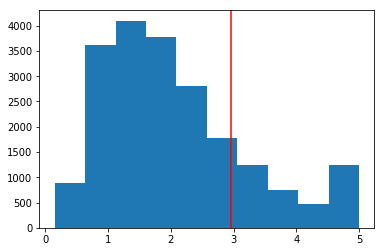

In [241]:
house_blocks = [[
    3.,
    12,
    2,
    1,
    2000,
    2.,
    33.93,
    -118.49
]]
scaled_house_blocks = scaler.transform(house_blocks)
print("Scaled values: ", scaled_house_blocks)

predicted_costs = ann.predict(scaled_house_blocks)
print("Predicted cost: ", predicted_costs)

plt.hist(calif.target)
plt.axvline(x=predicted_costs, c='red')
plt.show()

# Backpropagation

The heart of neural networks is [backpropagation algorithms](https://en.wikipedia.org/wiki/Backpropagation), which are an efficient way to change the weights and biases in the ANN based on the size of the loss.

In effect, an ANN is trained by:
1. Setting all weights and biases randomly.
2. For each row in the test data:
    1. Set the input units to the input features.
    2. Use unit weights and biases, passing through the activation function, to calculate the output value of each unit -- right through to the output units.
    3. Use a loss function to compare the output units with the expected output.
    4. Use a backpropagation algorithm to update all the weights and biases to reduce the loss.

Google has a [nice visual explanation](https://google-developers.appspot.com/machine-learning/crash-course/backprop-scroll/) of backpropagation. [More detailed explanations](http://neuralnetworksanddeeplearning.com/chap2.html) are also available.
    
## When backpropagation goes wrong

* Vanishing gradients: when weights for lower levels (closer to the input) become very small, gradients become very small too, making it hard or impossible to train these layers. The ReLU activation function can help prevent vanishing gradients.

* Exploding gradients: when weights become very large, the gradients for lower layers can become very large, making it hard for these gradients to converge. Batch normalization can help prevent exploding gradients, as can lowering the learning rate.

* Dead ReLU units: once the weighted sum for a ReLU activation function falls below 0, the ReLU unit can get stuck -- without an output, it doesn't contribute to the network output, and gradients can't flow through it in backpropagation. Lowering the learning rate can help keep ReLU units from dying.

* Dropout regularization: in this form of regularization, a proportion of unit activations are randomly dropped out. This prevents overfitting and so helps create a better model.

## ANN for classification: what sort of forest is this?
Let's jump in with a dataset called [Covertype](https://archive.ics.uci.edu/ml/datasets/Covertype), where we try to predict forest cover type based on a number of features of a 30x30m area of forest as follows:

| Column | Feature | Units | Description | How measured |
|---|--------|-------|-------------|--------------|
| 1 | Aspect | degrees azimuth | Aspect in degrees azimuth | Quantitative |
| 2 | Slope | degrees | Slope in degrees | Quantitative |
| 3 | Horizontal_Distance_To_Hydrology | meters | Horz Dist to nearest surface water features | Quantitative |
| 4 | Vertical_Distance_To_Hydrology | meters | Vert Dist to nearest surface water features | Quantitative |
| 5 | Horizontal_Distance_To_Roadways | meters | Horz Dist to nearest roadway | Quantitative |
| 6 | Hillshade_9am | 0 to 255 index | Hillshade index at 9am, summer solstice | Quantitative |
| 7 | Hillshade_Noon | 0 to 255 index | Hillshade index at noon, summer soltice | Quantitative |
| 8 | Hillshade_3pm | 0 to 255 index | Hillshade index at 3pm, summer solstice | Quantitative |
| 9 | Horizontal_Distance_To_Fire_Points | meters | Horz Dist to nearest wildfire ignition points | Quantitative |
| 10-14 | Wilderness_Area | 4 binary columns with 0 (absence) or 1 (presence) | Which wilderness area this plot is in | Qualitative |
| 14-54 | Soil_Type | 40 binary columns with 0 (absence) or 1 (presence) | Soil Type designation | Qualitative |

Using this information, we are trying to classify each 30x30m plot as one of seven forest types.

This dataset is built into Scikit, so we can use it to download and load the dataset for use.

In [243]:
from sklearn import datasets
help(datasets.fetch_covtype)

Help on function fetch_covtype in module sklearn.datasets.covtype:

fetch_covtype(data_home=None, download_if_missing=True, random_state=None, shuffle=False, return_X_y=False)
    Load the covertype dataset (classification).
    
    Download it if necessary.
    
    =================   ============
    Classes                        7
    Samples total             581012
    Dimensionality                54
    Features                     int
    =================   ============
    
    Read more in the :ref:`User Guide <covtype_dataset>`.
    
    Parameters
    ----------
    data_home : string, optional
        Specify another download and cache folder for the datasets. By default
        all scikit-learn data is stored in '~/scikit_learn_data' subfolders.
    
    download_if_missing : boolean, default=True
        If False, raise a IOError if the data is not locally available
        instead of trying to download the data from the source site.
    
    random_state : int, Rand

So we don't need to provide any arguments, but it warns us that it will need to download this dataset. It also describes the the returned dataset object will have the following properties:
- .data: a numpy array with the features.
- .target: a numpy array with the target labels. Note that each plot is classified into only one of these values.
- .DESCR: describe this forest covertype.

In [244]:
# Let's get the data pre-shuffled.
covtype = datasets.fetch_covtype(shuffle=True)

print("Data: ", covtype.data)
print("Data shape: ", covtype.data.shape)

Data:  [[2689.   78.    7. ...    0.    0.    0.]
 [2755.  252.   17. ...    0.    0.    0.]
 [2909.  121.    6. ...    0.    0.    0.]
 ...
 [3339.  180.   12. ...    0.    0.    0.]
 [2998.  153.    7. ...    0.    0.    0.]
 [2863.   19.   16. ...    0.    0.    0.]]
Data shape:  (581012, 54)


In [245]:
print("Target: ", covtype.target)
print("Target shape: ", covtype.target.shape)

Target:  [1 2 1 ... 7 2 2]
Target shape:  (581012,)


As before, we start by splitting our data into test and training data. We'll set aside 50,000 rows for testing, and use the remaining 531,012 rows for training.

In [246]:
# Out of 581,012 data entries, let's hold back:
# - 50,000 records as our test dataset
# - remaining records as our training dataset

test_data = covtype.data[0:50_000]
test_labels = covtype.target[0:50_000]

train_data = covtype.data[50_000:]
train_labels = covtype.target[50_000:]

print("Test data shape: ", test_data.shape)
print("Test labels shape: ", test_labels.shape)

print("Training data shape: ", train_data.shape)
print("Training labels shape: ", train_labels.shape)

Test data shape:  (50000, 54)
Test labels shape:  (50000,)
Training data shape:  (531012, 54)
Training labels shape:  (531012,)


Our data is ready for processing. But remember that we have a variety of different input types: binary (0, 1), continuous in small ranges (0-255) and in large ranges (elevations). Before we process this data, we should normalize them into a standard range. We'll use a MinMaxScaler: it reduces the range of all data so they fit into the range 0 to 1.

In [247]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Figure out how to scale all the input features in the training dataset.
scaler.fit(train_data)
scaled_train_data = scaler.transform(train_data)

# Also tranform our validation and testing data in the same way.
scaled_test_data = scaler.transform(test_data)

# Did that work?
pd.DataFrame(scaled_train_data).describe()

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
count,531012.000000,531012.000000,531012.000000,531012.000000,531012.000000,531012.000000,531012.000000,531012.000000,531012.000000,531012.000000,...,531012.000000,531012.000000,531012.000000,531012.000000,531012.000000,531012.000000,531012.000000,531012.000000,531012.000000,531012.000000
mean,0.550331,0.432391,0.213668,0.192807,0.283467,0.330134,0.835223,0.879231,0.561165,0.276114,...,0.044125,0.090086,0.077659,0.002800,0.003262,0.000202,0.000518,0.026832,0.023807,0.014979
std,0.140132,0.310852,0.113427,0.152036,0.075268,0.219087,0.105388,0.077805,0.150703,0.184744,...,0.205373,0.286306,0.267635,0.052844,0.057018,0.014194,0.022751,0.161592,0.152449,0.121469
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.475238,0.161111,0.136364,0.077309,0.232558,0.155122,0.779528,0.838583,0.468504,0.142777,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.568284,0.352778,0.196970,0.156049,0.262274,0.280596,0.858268,0.889764,0.562992,0.238427,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.652326,0.725000,0.272727,0.274875,0.312661,0.467332,0.909449,0.933071,0.661417,0.355549,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Classifying among multiple categories

Having multiple output units usually would result in each unit being considered independently, allowing you to assign multiple labels for a particular input (for instance, a single image might be classified as containing both a cloud as well as a bird). However, we use scikit-learn's [MLPClassifier](https://scikit-learn.org/stable/modules/neural_networks_supervised.html#classification), which automatically uses *softmax* to treat labels as exclusive to each other.

### The power of softmax

[Softmax](https://developers.google.com/machine-learning/crash-course/multi-class-neural-networks/softmax) is an activation function added to the output units that ensures that the sum of the outputs of all units in the output layer is 100%. The output of each individual unit is therefore the probability that it is the category into which the input should be categorized.

The result of this is that MLPClassifier can provide both a predicted label for a set of input features, as well as the probability that represents how certain the model is about this prediction.

In [254]:
from sklearn.neural_network import MLPClassifier

classifier = MLPClassifier(
    activation='relu',
    solver='adam',
    alpha=0.001,
    hidden_layer_sizes=(40, 20),
    batch_size='auto',
    verbose=True,
    early_stopping=True
)
classifier.fit(scaled_train_data, train_labels)

Iteration 1, loss = 0.71283513
Validation score: 0.735453
Iteration 2, loss = 0.61419805
Validation score: 0.744699
Iteration 3, loss = 0.59041971
Validation score: 0.751629
Iteration 4, loss = 0.57682487
Validation score: 0.754736
Iteration 5, loss = 0.56645683
Validation score: 0.761873
Iteration 6, loss = 0.55735183
Validation score: 0.762608
Iteration 7, loss = 0.55031222
Validation score: 0.767410
Iteration 8, loss = 0.54410482
Validation score: 0.770442
Iteration 9, loss = 0.53808131
Validation score: 0.774001
Iteration 10, loss = 0.53292197
Validation score: 0.772890
Iteration 11, loss = 0.52871875
Validation score: 0.776976
Iteration 12, loss = 0.52477191
Validation score: 0.778125
Iteration 13, loss = 0.52022548
Validation score: 0.784566
Iteration 14, loss = 0.51577150
Validation score: 0.782871
Iteration 15, loss = 0.51212686
Validation score: 0.780611
Iteration 16, loss = 0.50868450
Validation score: 0.789273
Iteration 17, loss = 0.50554156
Validation score: 0.788765
Iterat

MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(40, 20), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=True, warm_start=False)

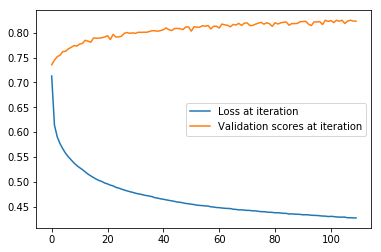

In [255]:
# Visualize the loss curve and validation scores over iterations.
plt.plot(classifier.loss_curve_, label='Loss at iteration')
plt.plot(classifier.validation_scores_, label='Validation scores at iteration')
plt.legend(loc='best')
plt.show()

In [256]:
classifier.score(scaled_test_data, test_labels)

0.82352

# What's next?

In the next part of this course, we will discuss the landscape of machine learning methods. Artificial neural networks are a valuable part of this landscape, and -- as you can see -- very easy to set up and try, but will not always be the best solution to the problem.